# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Setup

In [25]:
import pandas as pd
import sklearn as sk

alldata = pd.read_excel('alldata.xlsx')
drdata = pd.read_excel('drdata.xlsx')
drqdata = pd.read_excel('drq.xlsx')

tv2data = pd.read_excel('tv2data.xlsx')
tv2qdata = pd.read_excel('tv2q.xlsx')

electedData = pd.read_excel('electeddata.xlsx')

### 1. Age of the candidates grouped on parties

In [26]:
filtered_data = alldata[['parti', 'alder']].copy()

filtered_data['age_group'] = pd.cut(
    filtered_data['alder'],
    bins=[0, 30, 40, 50, 60, 70, 80],
    labels=['0-30', '31-40', '41-50', '51-60', '61-70', '71+']
)

age_group_analysis = filtered_data.groupby(['parti', 'age_group'], observed=False).size().unstack(fill_value=0)
age_group_analysis['mean_age'] = filtered_data.groupby('parti')['alder'].mean().round(2)
age_group_analysis['total_candidates'] = filtered_data.groupby('parti').size()

display(age_group_analysis)



age_group,0-30,31-40,41-50,51-60,61-70,71+,mean_age,total_candidates
parti,,,,,,,,
Alternativet,10,7,23,14,8,3,46.00,67
Danmarksdemokraterne,2,5,11,12,7,0,51.22,37
Dansk Folkeparti,7,7,16,15,3,1,45.53,49
Det Konservative Folkeparti,15,14,26,34,5,0,42.90,98
Enhedslisten,17,18,14,12,7,3,40.51,74
"Frie Grønne, Danmarks Nye Venstrefløjsparti",9,11,3,2,1,0,34.81,26
Kristendemokraterne,4,4,13,9,10,1,49.02,42
Liberal Alliance,21,18,16,8,4,1,36.89,70
Løsgænger,0,1,1,1,0,0,48.00,3


<Axes: xlabel='alder', ylabel='parti'>

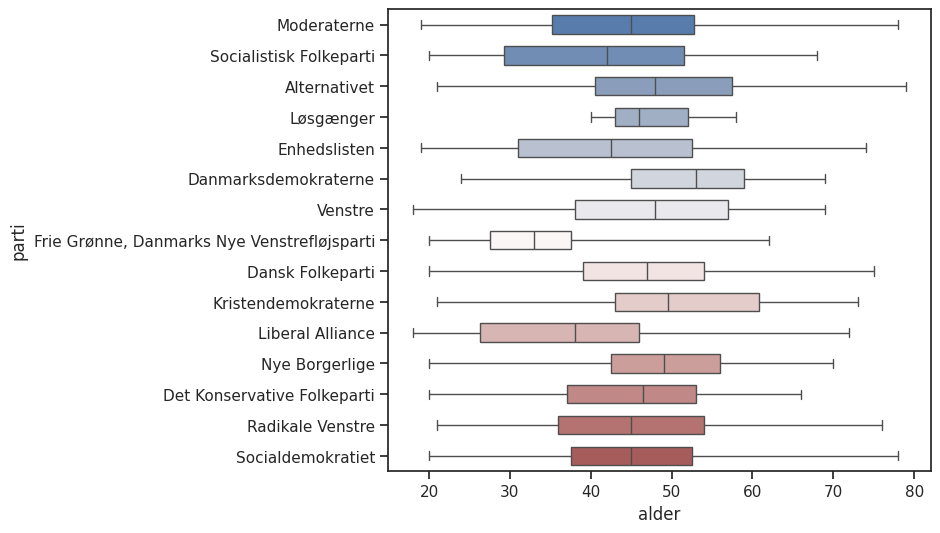

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

data = alldata[['parti', 'alder']]
data = data.dropna()
# Replace ages of 0 with the median age
median_age = data[data['alder'] > 0]['alder'].median()
data['alder'] = data['alder'].replace(0, median_age)

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x='alder', y='parti', data=data, whis=[0, 100], width=.6, hue='parti', palette="vlag", legend=False)


### An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.


In [28]:
confident_data = alldata[['parti', 'navn']]
confident_data = confident_data.dropna()
confident_data

cleaned_data = alldata.drop(columns=['parti', 'navn', 'alder'])


confident_data['confident_responses'] = cleaned_data.apply(lambda row: (row == 2).sum() + (row == -2).sum(), axis=1)
confident_data.sort_values('confident_responses', ascending=False).head(10)



,parti,navn,confident_responses
505,Enhedslisten,Sarah Nørris,49
88,Det Konservative Folkeparti,Søren Vanting,49
559,Nye Borgerlige,Kim Andkjær Doberck,44
44,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Mohamed Abdikarim,43
152,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Rashid Ali,43
503,Enhedslisten,Jan Filbært,42
437,Dansk Folkeparti,Lone Vase Langballe,42
284,Nye Borgerlige,John Bjerg,42
359,Dansk Folkeparti,Frank Sørensen,42
151,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Elise Bjerkrheim,42


In [29]:
overview = alldata[['navn', 'parti', 'alder']].dropna()

# Clearing the data to only the questions as fetures
survey = alldata.drop(columns=['parti', 'navn', 'alder', 'storkreds'])

# Clearing the code logic by extracting the number of questions
num_questions = survey.shape[1]

# Extracting the name of the column for easier refactoring
confidence = 'confidence_%'

# Mapping each row (axis=1) to the percentage of confident answers (2 or -2)
overview[confidence] = survey.apply(lambda row: (row.isin([-2, 2]).sum() / num_questions * 100).round(2), axis=1)
overview.sort_values(confidence, ascending=False).head(10)

,navn,parti,alder,confidence_%
505,Sarah Nørris,Enhedslisten,43,100.00
88,Søren Vanting,Det Konservative Folkeparti,50,100.00
559,Kim Andkjær Doberck,Nye Borgerlige,43,89.80
44,Mohamed Abdikarim,"Frie Grønne, Danmarks Nye Venstrefløjsparti",33,87.76
152,Rashid Ali,"Frie Grønne, Danmarks Nye Venstrefløjsparti",38,87.76
503,Jan Filbært,Enhedslisten,57,85.71
437,Lone Vase Langballe,Dansk Folkeparti,52,85.71
284,John Bjerg,Nye Borgerlige,58,85.71
359,Frank Sørensen,Dansk Folkeparti,58,85.71
151,Elise Bjerkrheim,"Frie Grønne, Danmarks Nye Venstrefløjsparti",48,85.71


### Display of internal party disagreements variance and of all persons

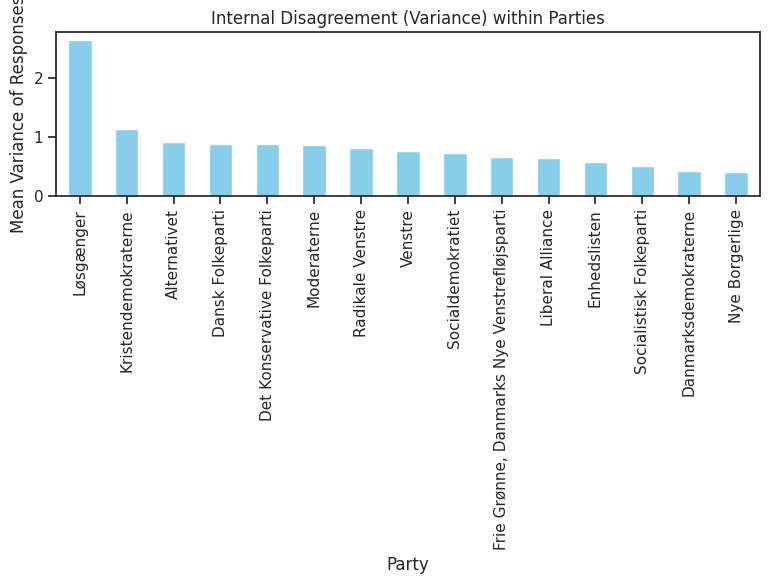

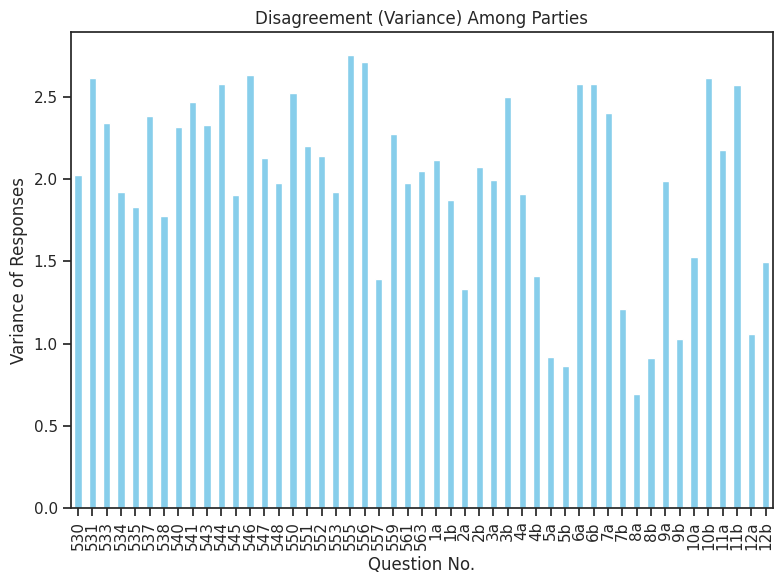

In [30]:
df =  pd.read_excel('alldata.xlsx')

# 1. Inter-party differences: Calculate mean response per party for all questions
question_columns = list(df.columns[:25]) + list(df.columns[27:51])  

# 2. Intra-party disagreements: Calculate variance of responses within each party
variance_responses_by_party = df.groupby('parti')[question_columns].var()

# 3. Aggregating variances to determine overall internal disagreement by party
party_internal_disagreement = variance_responses_by_party.mean(axis=1).sort_values(ascending=False)

def plot_internal_disagreement():
    plt.figure(figsize=(8,6))
    party_internal_disagreement.plot(kind='bar', color='skyblue')
    plt.title('Internal Disagreement (Variance) within Parties')
    plt.xlabel('Party')
    plt.ylabel('Mean Variance of Responses')
    plt.tight_layout()
    plt.show()

plot_internal_disagreement()

parties_disagreement = df[question_columns].var()

def plot_all_parties_disagreement():
    plt.figure(figsize=(8,6))
    plt.title('Disagreement (Variance) Among Parties')
    plt.xlabel('Question No.')
    plt.ylabel('Variance of Responses')
    parties_disagreement.plot(kind='bar', color='skyblue')
    plt.tight_layout()
    plt.show()

plot_all_parties_disagreement()

In [31]:
# Clear data and leave only candidates' parties and questions
survey = alldata.drop(columns=['navn', 'alder', 'storkreds'])

# Calculate standard deviation of responses grouped by 'parti'
survey_std = survey.groupby('parti').std().round(2).reset_index()

# Calculate the total standard deviation per row and add it to a 'total' column
survey_std['total'] = survey_std.iloc[:, 1:].sum(axis=1)
survey_std = survey_std.sort_values('total', ascending=True)
survey_std

,parti,530,531,533,534,535,537,538,540,541,...,8b,9a,9b,10a,10b,11a,11b,12a,12b,total
10,Nye Borgerlige,0.46,0.24,0.98,0.53,0.20,0.76,0.14,0.33,0.69,...,0.62,0.73,0.62,0.37,0.93,0.20,0.00,0.94,0.81,27.55
1,Danmarksdemokraterne,0.73,0.55,0.90,0.73,0.49,0.97,0.42,0.66,0.36,...,0.65,0.55,0.57,0.68,0.28,0.16,0.31,0.65,0.78,29.83
13,Socialistisk Folkeparti,0.35,0.40,0.71,0.30,0.57,0.32,0.63,0.42,0.56,...,0.72,0.59,0.91,0.68,0.46,0.94,0.89,0.78,0.87,32.54
5,"Frie Grønne, Danmarks Nye Venstrefløjsparti",0.27,0.27,0.00,0.47,0.43,0.00,0.65,0.86,0.88,...,1.07,0.93,1.33,1.56,0.75,1.07,1.02,1.06,1.25,32.71
4,Enhedslisten,0.26,0.38,0.27,1.29,0.63,0.37,1.29,0.44,0.54,...,1.05,0.42,0.90,0.96,0.34,1.00,0.86,1.06,1.17,33.27
7,Liberal Alliance,0.75,0.17,1.15,0.74,0.63,0.30,0.00,0.17,0.88,...,0.98,0.86,0.82,0.56,0.26,0.20,0.34,0.65,1.00,35.81
12,Socialdemokratiet,0.96,0.99,1.10,0.52,0.61,0.70,0.90,0.68,1.20,...,0.76,0.79,0.68,0.79,0.31,0.52,0.46,0.94,0.89,40.45
14,Venstre,0.86,0.50,1.14,0.51,0.61,0.70,0.26,0.62,0.96,...,0.73,1.02,0.77,0.63,1.03,0.40,0.39,0.60,1.08,40.90
11,Radikale Venstre,0.58,0.94,0.45,0.12,1.02,1.01,1.21,0.96,1.28,...,0.86,0.94,0.97,0.93,1.17,0.76,1.10,0.85,1.08,42.00
3,Det Konservative Folkeparti,1.08,0.33,1.27,0.67,0.39,0.78,0.14,0.54,1.03,...,0.81,1.02,0.98,0.76,0.68,0.42,0.45,0.78,1.12,43.49


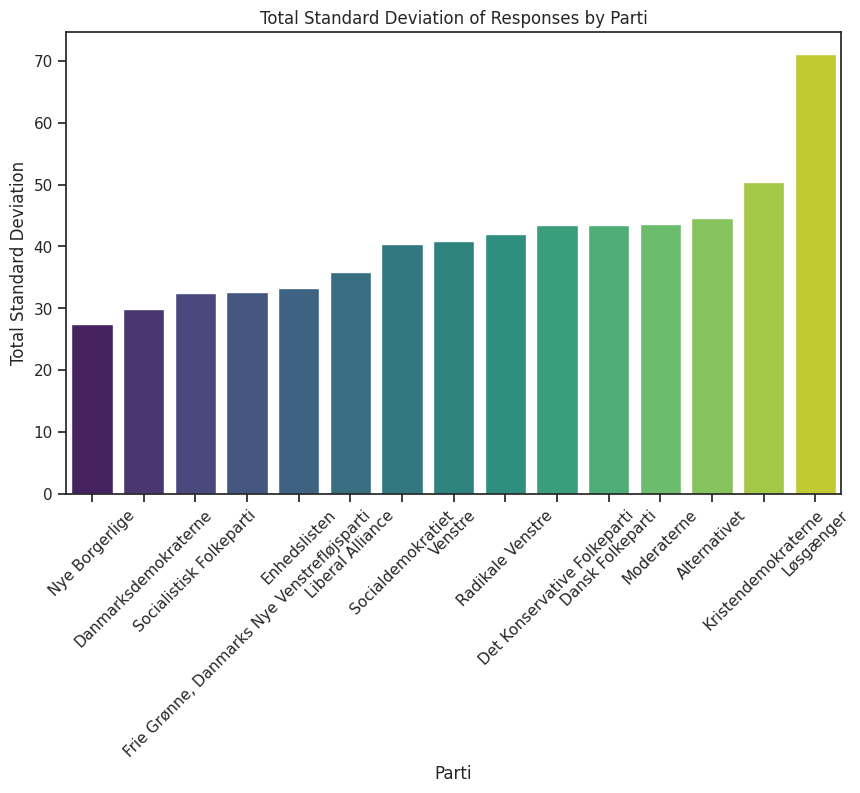

In [32]:
# Creating a bar plot to visualize the total standard deviation of responses by parti (inner party disagreement)
#  The lower the better for agreement
plt.figure(figsize=(10, 6))
sns.barplot(x='parti', y='total', data=survey_std, hue='parti', palette="viridis", legend=False)
plt.xlabel('Parti')
plt.ylabel('Total Standard Deviation')
plt.title('Total Standard Deviation of Responses by Parti')
plt.xticks(rotation=45)
plt.show()

### Correlation Map

parti        1.000000
531          0.518727
541          0.430299
555          0.416257
543          0.410105
6b           0.400160
535          0.399983
3a           0.399362
563          0.386954
530          0.371468
6a           0.364659
4a           0.363813
545          0.363524
537          0.353621
550          0.347400
548          0.334960
3b           0.331022
557          0.320877
2a           0.314278
544          0.295743
1a           0.275958
540          0.273887
533          0.273832
7b           0.265187
1b           0.264199
10b          0.255420
10a          0.244719
556          0.235374
559          0.226727
551          0.224222
8b           0.222873
9a           0.222450
2b           0.215820
552          0.207074
7a           0.197378
4b           0.172984
12a          0.172835
546          0.156788
8a           0.156538
9b           0.156401
11a          0.143759
547          0.117468
538          0.103230
561          0.079542
5a           0.072764
5b        

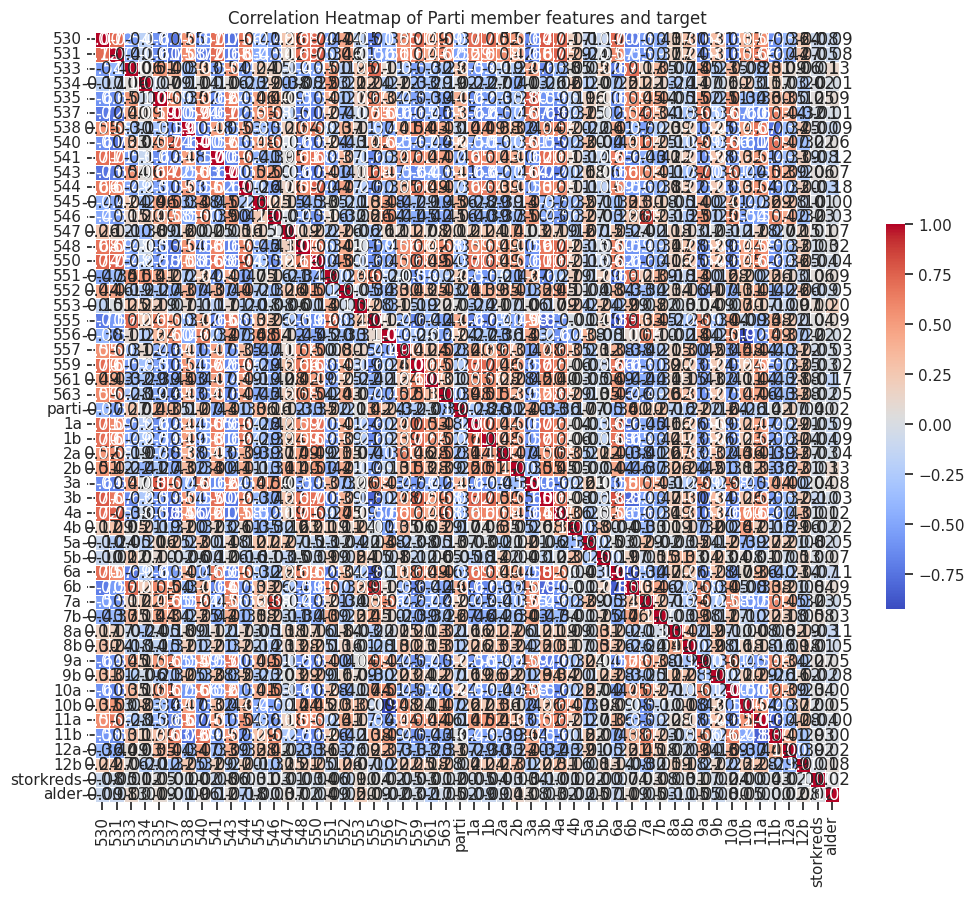

In [33]:
data = alldata
data = data.dropna()
# Replace ages of 0 with the median age
median_age = data[data['alder'] > 0]['alder'].median()
data['alder'] = data['alder'].replace(0, median_age)
data = data.drop(["navn"], axis='columns')
data.columns

parties = data["parti"].unique()
parties_mapping = {party: index for index,party in enumerate(parties)}
data["parti"] = data["parti"].map(parties_mapping)

areas = data["storkreds"].unique()
areas_mapping = {area:index for index,area in enumerate(areas)}
data["storkreds"] = data["storkreds"].map(areas_mapping)

#data

corr = data.corr()

# init a matplotlib figure for displaying
plt.figure(figsize=(12, 10))

# use seaborn for a neat heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={'shrink': .5})

# we can also add a title
plt.title('Correlation Heatmap of Parti member features and target')

#plt.show()["parti"]
corr["parti"].abs().sort_values(ascending=False)

### KNN Classification

Classification Report:
                                             precision    recall  f1-score   support

                               Alternativet       0.92      0.71      0.80        17
                       Danmarksdemokraterne       1.00      1.00      1.00         9
                           Dansk Folkeparti       1.00      0.83      0.91        12
                Det Konservative Folkeparti       0.88      0.88      0.88        25
                               Enhedslisten       1.00      1.00      1.00        19
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.83      0.83      0.83         6
                        Kristendemokraterne       0.89      0.80      0.84        10
                           Liberal Alliance       0.89      1.00      0.94        17
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       1.00      0.90      0.95        10
                             Nye Borgerli

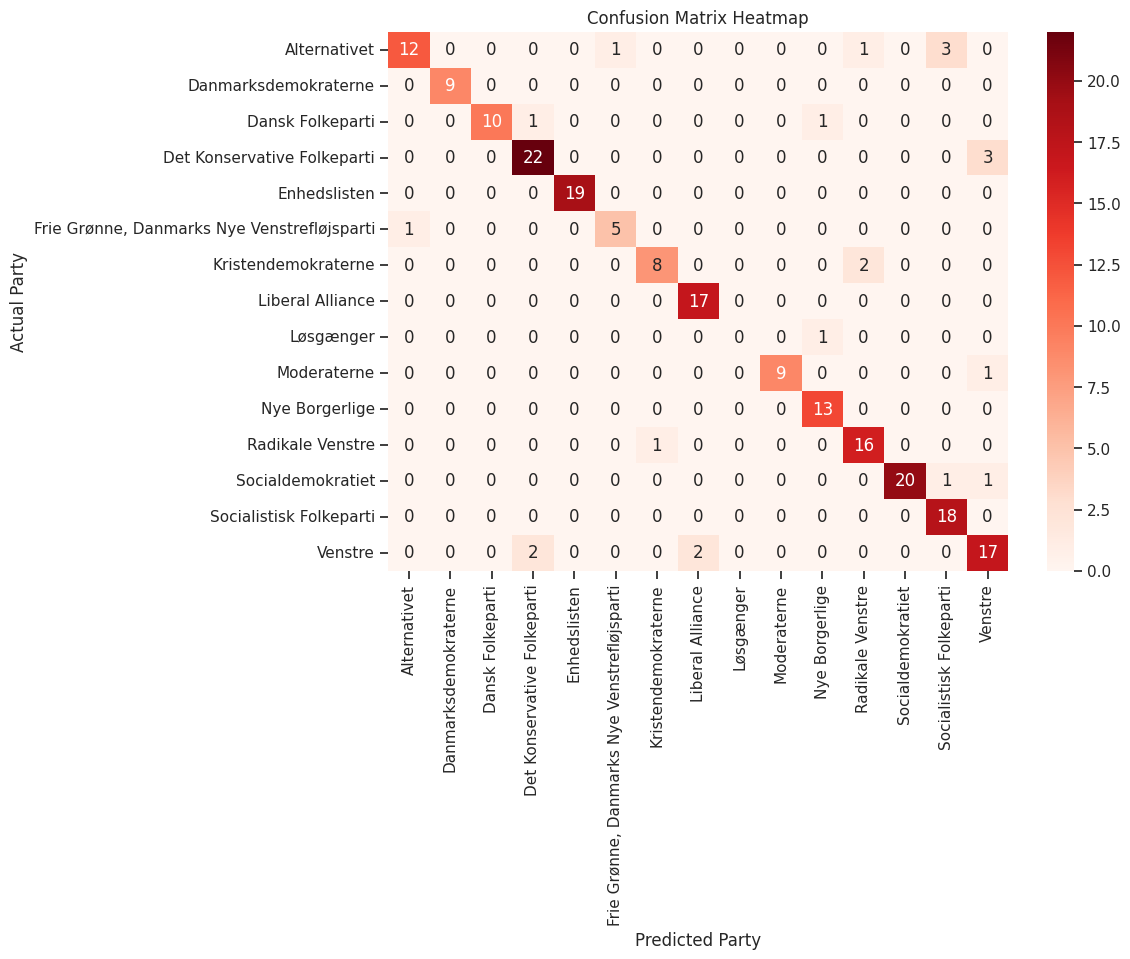

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

X = alldata.drop(columns=['parti', 'navn', 'alder', 'storkreds'])  # dropping everything except the answers of the questions
y = alldata['parti']  # Target: political pattern

# encode target labels to numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=0)

# with pipeline with StandardScaler and KNeighborsClassifier
# knn = Pipeline(
#     steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=29, weights="distance"))]
# )

# n_neighbors=29 is the hyperparameter K, we found 29 to be the best value by setting it to the square root of sample size [sqrt(867) = 29.4]
knn = KNeighborsClassifier(n_neighbors=29, weights="distance");

# train the KNN model
knn.fit(X_train, y_train)

# evaluate the model on the test set
y_pred = knn.predict(X_test)

print("Classification Report:")
# zero_division=0 because of the warnings of something getting deprecated in the future
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))


# confusion matrix - use to verify and asses the performance of the knn model
cm = confusion_matrix(y_test, y_pred)

# convert y_encoded labels back to original party names
party_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=party_names, yticklabels=party_names)
plt.xlabel("Predicted Party")
plt.ylabel("Actual Party")
plt.title("Confusion Matrix Heatmap")
plt.show()



                                             precision    recall  f1-score   support

                               Alternativet       0.83      0.88      0.86        17
                       Danmarksdemokraterne       1.00      1.00      1.00         9
                           Dansk Folkeparti       0.92      0.92      0.92        12
                Det Konservative Folkeparti       0.74      0.92      0.82        25
                               Enhedslisten       1.00      0.95      0.97        19
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.86      1.00      0.92         6
                        Kristendemokraterne       0.82      0.90      0.86        10
                           Liberal Alliance       1.00      1.00      1.00        17
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       1.00      0.90      0.95        10
                             Nye Borgerlige       0.92      0.92

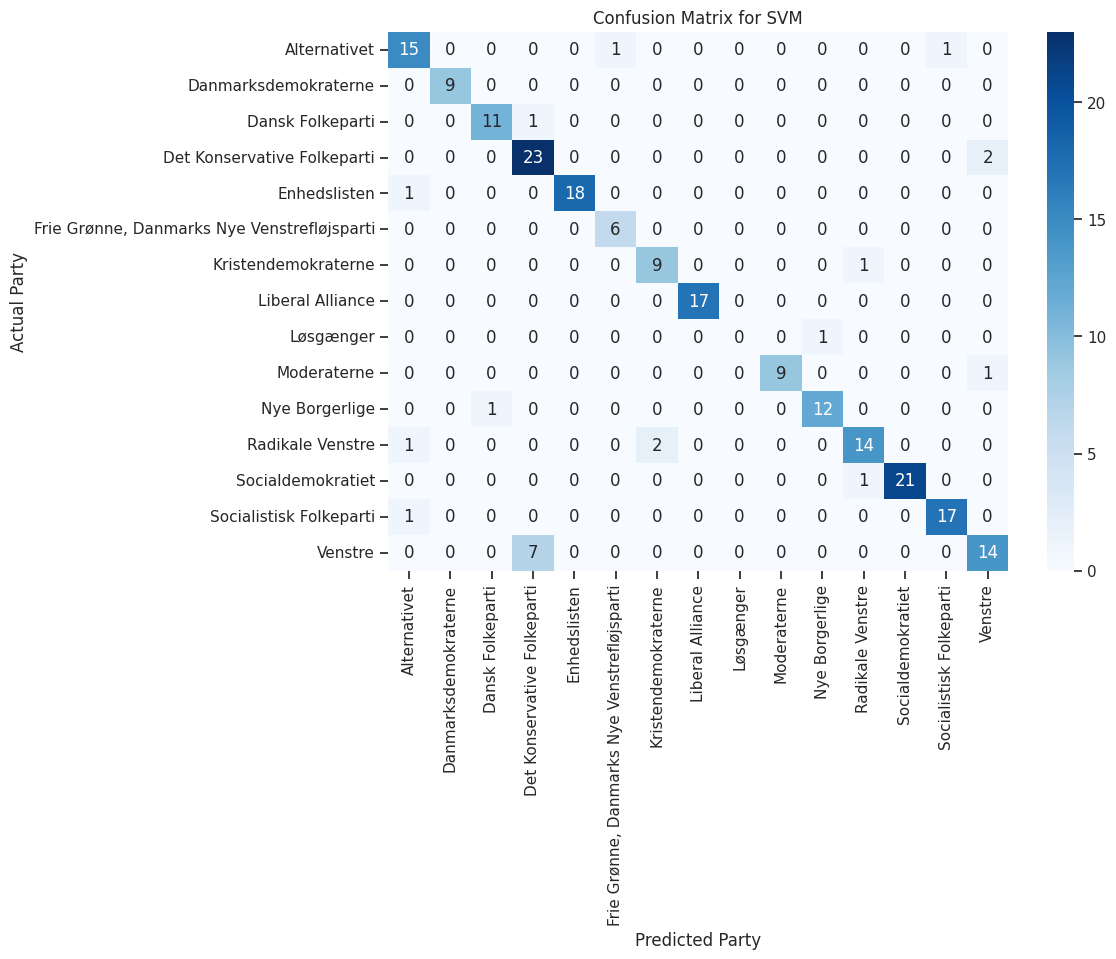

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# splitting the dataset into training and testing sets
# stratify=y ensures that the proportion of classes in y is preserved in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# # the sigmoid kernel
# svm = SVC(kernel='sigmoid', random_state=100)

# Using the RBF kernel (Radial Basis Function), the default and most commonly used kernel for SVM
svm = SVC() 

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel("Predicted Party")  
plt.ylabel("Actual Party") 
plt.title("Confusion Matrix for SVM") 
plt.show()
